In [ ]:
 # This is the same code from the previous section, nothing new here.
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custon style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

# 7.0 Kinova Gen 3 Robotic Arm Pick and Place Controller


## Table of Contents

> #### 7.1 Introduction
> #### 7.2 Sequence of Mathematical Methods and Computer Vision in the Pick and Place Code
> #### 7.3 Breakdown of Pick and Place Code (*kinova_pick_and_place_code.py*)
> #### 7.4 Set-Up and Guide for Pick and Place Code (*kinova_pick_and_place_code.py*)



## 7.1 Introduction
----
Over the course of this tutorial, you have learnt and built a foundation for the mathematical methods andtechniques that will be involved in our installment of robotic arm control.

In Part 1 of the tutorial, we delved into the fundamentals of forward kinematics, exploring the mathematical relationships that describe the position and velocity of the robotic arm's end-effector. Leveraging this knowledge, we will demonstrate how to apply forward kinematics calculations to accurately control the arm's movements in three-dimensional space when joint angles of the robotic arm are accquired.

Building upon this foundation, Part 2 introduced the intricacies of inverse kinematics, focusing on the functions required for resolved rate motion control and the numerical methods for computing the desired joint angles based on the desired position of the arm's end-effector. In this notebook, we will show the implementation of the trust constraint method to determine the joint configurations required to achieve our desired end-effector positions.

In this final installment of our educational tutorial, we will bring together all the concepts and techniques covered in the previous parts to implement a fully functional pick and place controller for the Kinova Gen 3 robotic arm.

To skip the mothdolodgy and final design of the controller, skip to section 7.4.

## 7.2 Sequence of Mathematical Methods and Computer Vision in the Pick and Place Code
----

To begin this section, we will start by examining figure 1 below, which outlines the schematic of the pick and place process designed to place three cubes, sized from small, medium, and large, on top of one another in a stacked formation.

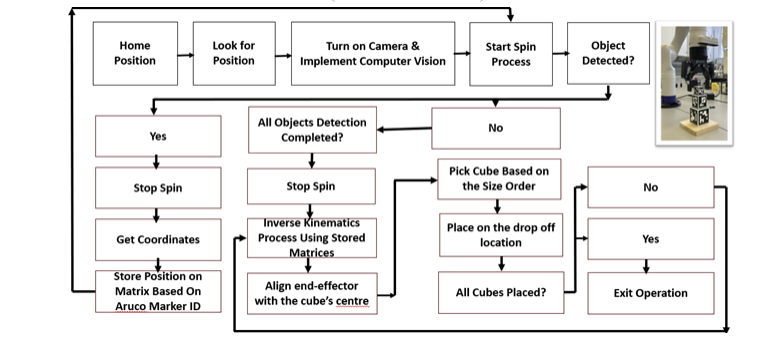
<br>
**Figure 1: Schematic of the Pick and Place Controller Process**

It is a sophisticated process designed using Python to autonomously manipulate objects using the Kinova Gen3 Robotic Arm with 7 DOF and requires the arm to be equipped with computer vision capabilities, a topic that was learnt in the previous notebook with snippets of our self-made computer vision codes and functions.

The operation begins with the arm positioned at the Home Position, from where it transitions to the Look Position to activate the camera for its computer vision functionality.

The **home position** essentially positions the arm so half of it is vertical and the other half is horizontal, creating a 90 degree bend. The **look position** is seen when the arm bends back in on itself positioning the camera directly above the base while remaining close to the ground. This puts the camera in a position where it is able to get a good view of the table and the cubes. Utilizing computer vision techniques with ArUco markers, the system then initiates a spin process while simultaneously conducting object detection to locate the three previoously mentioned cubes and the drop-off plate, each marked with unique ArUco IDs for the camera to recognize.

During the spin process, the system continuously scans the robot's workspace. Upon detecting an object during the spin process, the system halts both the spin and detection processes, and proceeds to retrieve the object's coordinates. It proceeds to retrieve the object's coordinates by accurately estimating its pose in the camera frame. This involves identifying the ArUco marker's corners and computing rotation and translation vectors based on the detected marker corners and the camera matrix. These calculated coordinates are then stored in a designated matrix corresponding to the object's ArUco ID. This iterative process continues until all four objects are successfully detected and their coordinates recorded. These coordinates are stored in a designated matrix corresponding to the object's ArUco ID.  

Once all objects are located, the system ceases the spin and detection processes, directing the end effector to the drop-off location to acquire precise coordinates. Subsequently, the inverse kinematics process is initiated using the Trust Region Constraint Method we learned in the beginning of part 3 for this tutorial to calculate the joint angles necessary for picking the largest cube and placing it onto the drop-off location.

Employing computer vision once more, the end effector aligns precisely with the center of the target cube before descending to grasp it with the gripper. Upon successfully gripping the cube, it is then lifted and transported to the drop-off location. This process repeats sequentially for the medium and small cubes, stacking them on top one another in order of size at the designated drop-off location as seen on the top right corner of figure 1.

Through the orchestrated combination of these methodologies, the pick-and-place controller achieved efficient and reliable object manipulation, demonstrating the versatility and effectiveness of advanced robotic systems in real-world applications.

## 7.3 Breakdown of Pick and Place Code (*kinova_pick_and_place_code.py*)
----

The python file that contains the pick and place controller code is titled **kinova_pick_and_place_code.py**. It is located under the
<br><br>
*Kinova-Gen-3-Robotic-Arm-Pick-and-Place-Controller-Tutorial>PICK_PLACE>Python Pick and Place Files>kinova_pick_and_place_code.py*
<br><br>
folder directory in this project's repository.

Since the entire raw file itself is over 1200 lines of code long, we will breakdown the code to smaller, brief sections to highlight the code strcuture and understand some new defined functions not previously discussed. Whether you're looking to execute the existing code or customize it to suit your specific requirements, this section will equip you with the necessary knowledge to navigate and modify the code effectively.

The first breakdown section of the code we will look at is the imports:

```
import multiprocessing
import subprocess
import cv2
import cv2.aruco as aruco
from smallest_angular_distance import smallest_angular_distance_limits
from smallest_angular_distance import smallest_angular_distance_nolimits
from angle_guess import angle_guess
from trust_constr import trust_constr
from Rx import Rx
from Ry import Ry
from Rz import Rz
from T import T
from SM import SM
from CM import CM
from NR import NR
from WM import WM
from GN import GN
from fk import fk
from kortex_api.autogen.client_stubs.BaseClientRpc import BaseClient
from kortex_api.autogen.client_stubs.BaseCyclicClientRpc import BaseCyclicClient
from kortex_api.autogen.messages import Session_pb2, Base_pb2
import sys
import os
import time
import threading
import numpy as np
from close_gripper import close_gripper
from kortex_api.Exceptions.KServerException import KServerException
from kortex_api.autogen.messages import Base_pb2, BaseCyclic_pb2, Common_pb2
from get_angles_pose import get_angles_pose
from kortex_api.autogen.client_stubs.VisionConfigClientRpc import VisionConfigClient
from kortex_api.autogen.messages import Session_pb2, VisionConfig_pb2
```

A few of the imports should seem familar since they are previously defined functions we covered in earlier parts of the tutorial (*ie. Rx, Ry, Rz from Part One: Foward Kinematics*).

However there are some imports that are libraries which might not be already installed on your computer. These libraries include:

* multiprocessing
* subprocess
* <font color="red">cv2</font>
* sys
* os
* time
* threading
* <font color="red">numpy</font>
* <font color="red">kortex_api</font>

Typically, modules such as *multiproccessing, subprocess, sys* ... etc, are pre-installed that come with most Python distributions.

The libraries in <font color="red">red</font> are ones not included as standard Python modules that are in the Python standard library from your initial Python download. These will need to be installed seperatlely from your **python terminal** or **command prompt** using the following code below. The other libraries can also be installed the same way should they not already be installed.

*Note: The kortex API python package provided by Kinova cannot be installed with pip as it is not avaiable on the Python Package Index (PyPI). It should already be installed from the M2 training and quiz modules. Please refer to README.md for more information.*



In [ ]:
#the '%' is included here in the jupyter notebook for the code block to run.
%pip install opencv-python
%pip install numpy

The two lines of code underneath the imports of libraries and modules shows



```
TIMEOUT_DURATION = 10000
global_return_values = []
```

The variable **TIMEOUT_DURATION** represents the value of a timeout duration of 10000 ms (milliseconds)that is needed to ensure that pick and place process does not hang indefinitely. This concept is important especially in multiprocessing or multithreading scenarios where communication between different processes or threads is involved.

The array **global_return_values** is meant to act as a tracker that updates a value from 1 through 4 depending on which cube or base is detected depending on the AruCo marker index. The small cube is 1, medium cube is 2, large cube is 3, and the base destination plate is 4. The order of which value is updated does not matter. From 7.3, we can recognize the importance of initiating this global array since once the array has all values from 1 through four, the script will cease all previous processes and begin the pick and place process.

In [ ]:
#Example of how the array global_return_values will be defined once all objects are detected:

#ORDER: small cube, base plate, medium cube, large cube
global_return_values_example = [1,4,2,3]
print(global_return_values_example)

#QUESTION:
#What would the value of global_return_values from the order of base plate, large cube, small cube, medium cube?
global_return_values = #INSERT VALUE HERE
print(global_return_values)

The next part of the code we need to look at involves a bunch of functions defined in the script. These functions are crucial for making the arm move, and they're called within the main loop towards the end of the script. This section is quite lengthy, almost 1000 lines. Instead of going through all of it in detail, we'll just list the function names and provide brief descriptions to explain what each one does. Some functions have descriptions and information about their arguments, while others don't, so we'll include brief explanations for those.
<br>
<br>
**move_to_home_position(base):**
* This function is responsible for moving the robotic arm to a predefined home position and sets the arm's servoing mode to single level servoing to control the arm's movement. This function is essential for ensuring that the arm starts from a known safe position before performing other tasks.
<br>

**check_for_end_or_abort(e):**
* This function returns a closure that checks for END or ABORT notifications during an action execution.
<br>

**look_position():**
* This function is responsible for moving the robotic arm to a specific angular position by initializing the connection to the robot, sets up the desired joint angles, and executes the action.
<br>

**spin(switch):**
* This function controls the spinning motion of the robotic arm by It continuously adjusting the joint speeds based on the value of the switch. If the switch is set to 1, it spins the arm with specified speeds. If the switch is set to 2, it pauses the spinning motion and if the switch is set to 0, it stops the spinning motion immediately.
<br>

**camera_coor(pose):**
* This function calculates the transformation matrix for the camera's coordinates based on the pose and takes the position and orientation of the camera as input and computes the transformation matrix. This function is essential for converting the camera's pose into a format that can be used for further calculations or transformations.
<br>

**controller_vision_find(switch, global_return_values, coordinates):**
* This function performs marker detection using the camera attached to the robotic arm and updates the global_return_values array based on the detected markers and coordinates of the robotic arm. It also updates the switch value to control the spinning motion based on the detected markers.
<br>

**EOP(switch, coordinates):**
* This function performs marker detection and estimation of pose (position and orientation) using a camera attached to the robotic arm. Based on the detected markers and their pose, it updates the coordinates of the robotic arm's end effector.
<br>

**go_home():**
* This function moves the robotic arm to a predefined home position using the previously mentioned move_to_home_position function. It is useful for resetting the arm to a standard position after completing a task or movement.
<br>

**align(base, base_cyclic,pose,x,y):**
* This function is used to move a robotic arm to a specified Cartesian position (x, y, z, theta_x, theta_y, theta_z). It constructs an action message to send to the robot, sets the target pose, executes the action, and waits for the movement to finish.
<br>

**dangles(angles1,angles2)**
* This function computes the smallest angular distance between corresponding elements of two arrays angles1 and angles2, which represent joint angles.
<br>

**euler_to_rotation_matrix(z, y, x):**
* This fucntions converts Euler angles (in degrees) to a 3x3 rotation matrix using the ZYX convention. It constructs rotation matrices for rotations around the Z, Y, and X axes, and then combines them to obtain the final rotation matrix.
<br>

**rotation_to_nearest_perpendicular(A, B):**
* Given two rotation matrices A and B, this function calculates the rotation angle required to align B with a principal axis (X or Y axis) nearest to A.
<br>

**section_orientation(x, y):**
* This function calculates the orientation matrix of a circle section based on the given Cartesian coordinates (x, y) by first computing the angle in radians from the positive x-axis and then determines the section based on the angle range.
<br>

**send_joint_speeds(base,speeds,t)** and **send_joint_speeds1(base,speeds,t):**
* These functions send joint speeds to the robot for a specified duration t. They construct a message containing joint speeds for each actuator and send the command to the robot.
<br>

**calibrate(base, base_cyclic, P):**
* This function is similar to the previously mentioned align function, but is specifically designed for calibration purposes. It moves the robot arm to a specified Cartesian position P and waits for the movement to finish.
<br>

**rot2eul_zyx(R):**
* This function converts a 3x3 rotation matrix to Euler angles (in degrees) using the ZYX convention while checking for singularities to compute accordingly.
<br>

**vision(base, size)** and **base_vision(base, size):**
* These functions capture video from a camera, detect ArUco markers, estimate their poses, and calculate transformation matrices A based on the detected markers' positions.
<br>

**move(base, base_cyclic, pose, x, y, z):**
* This function performs a Cartesian action movement by adjusting the position of a robotic arm in Cartesian coordinates based on specified increments in the x, y, and z directions relative to a given pose.
<br>

**go_base(t,coordinates, angles, base_coor):**
* This function is responsible for moving the robotic arm to a predefined base position. It involves setting up the necessary connections to the robotic device, calibrating its position, and adjusting joint speeds for movement.
<br>

**drop(t, base_coor, angles,x):**
* This function handles the process of dropping an object by moving the robotic arm to a specified position above the base, adjusting joint speeds, and releasing the gripper.
<br>

**pick_up_L(t, coordinates, angles)**, **pick_up_M(t,coordinates, angles)** and **pick_up_S(t,coordinates, angles):**
* These function pick up a large, medium, or small object using the robotic arm. It involves setting up connections, calibrating the arm's position, aligning the arm with the object's position using vision data, and gripping the object.
<br>

**gripper(width)**
* This function controls the gripper of the robotic arm, allowing it to open or close based on the specified width parameter.
<br>

**calc(coordinates, angles):**
* This function calculates the joint angles required for the robotic arm to reach specific positions in Cartesian space. It continuously checks for each section (base, large, medium, small) if the angles are calculated and, if not, computes them using optimization algorithms until all angles are determined.





Lastly, at the end of the script we have the main function that manages concurrent tasks in a robotic system efficiently to coordinate shared data. This is possible because of the multiprocessing functionality in Python. The steps of how the main function runs is given below:

<br>

1. **Multiprocessing Setup:** It imports the multiprocessing module and creates a Manager instance to facilitate communication between processes.
2. **Shared Data Structures:** It creates several shared data structures (manager.dict and manager.list) to store coordinates, angles, a switch value, and other information that needs to be accessed or modified by multiple processes.
3. **Process Definition:** It defines multiple processes, each responsible for different tasks such as looking for objects (look_position), controlling the end-of-program signal (EOP), vision-based object detection (controller_vision_find), and more.
4. **Starting Processes:** It starts the necessary processes one by one using the start() method.
5. **Joining Processes:** It waits for certain processes to complete their tasks using the join() method. For example, the calc_process must finish calculating angles before proceeding.
6. **Task Execution:** Once certain conditions are met (e.g., when all necessary coordinates and angles are available), it terminates some processes and starts others to perform actions like picking up objects, dropping them, or moving the robotic arm to a base position.
7. **Termination:** It ensures that all processes are terminated properly to prevent resource leaks and unwanted behavior.
<br>

Once the initial processes are completed, the function initiates further actions based on certain conditions. If all necessary coordinates and angles are obtained, it terminates some processes related to object detection and calculation. Then, it sequentially starts processes to move the robot to the base, pick up a large cube, drop it, pick up a medium cube, drop it, pick up a small cube, and drop it.

## 7.4 Set-Up and User-Guide for Pick and Place Code (*kinova_pick_and_place_code.py*)
----

**Requirements:**

Access to a Kinova Gen 3 Arm: University of Calgary students can find instructions on how to access the arm on campus in the README.md file.

Cubes: Cubes required for the Gen 3 robotic arm will be provided.

Platform: You'll need a platform such as Visual Studio and Visual Studio Code to establish connection with the arm and run the scripts. Installation tutorials for these platforms are available in the Installation_Tutorials folder of the repository.

**Instructions:**

1. Follow the instructions provided in the M2 training to connect your laptop to the arm. We recommend using an ethernet connection for a quick and reliable connection.

2. Place the small, medium, and large cubes around the table where the arm is set up, ensuring they are within the camera's reach (roughly 50cm from the base).
Position the base plate within the camera's range. Ensure that no objects (base or cubes) overlap in the camera's frame, as this may affect object detection.

3. Navigate to the location of the pick and place script: Kinova-Gen-3-Robotic-Arm-Pick-and-Place-Controller-Tutorial > PICK_PLACE > Python Pick and Place Files > kinova_pick_and_place_code.py. Edit line 776 of the script to match the location of the repository on your computer (change the string variable vision_sensor_focus_action_filepath). Run the Python file by clicking on the run button in the top-right or top-left corner, depending on your application.

4. Once the run button is pressed, get ready to witness the magic of automation as you watch the Kinova Gen 3 Robotic Arm flawlessly execute its tasks with precision and efficiency!



